# Nearby Gaia Stars
## MSP, 6 January 2021

Look at a nearby sample (r<250 pc) of Gaia stars. Good for HR diagram, U-V plane.


In [1]:
# standard python modules
import numpy as np

# plotting utilities
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['ytick.minor.visible'] = True

import matplotlib.cm as cm
%matplotlib inline

# ipython reload capabilities for edits to external code
%load_ext autoreload
%autoreload 2


# easy hist_2d definition for my own purposes
def hist_2d(x,y,xbins,ybins,weights=None):
    
    if weights is None:
        weights = np.ones(x.size)
    
    dx = np.abs(xbins[1]-xbins[0])
    dy = np.abs(ybins[1]-ybins[0])
    img = np.zeros([xbins.size,ybins.size])
    Nxindx = (np.floor((x - np.nanmin(xbins))/(dx))).astype('int')
    Nyindx = (np.floor((y - np.nanmin(ybins))/(dy))).astype('int')

    for xval in range(0,xbins.size):
        for yval in range(0,ybins.size):
            w = np.where((Nxindx==xval) & (Nyindx==yval))[0]
            if len(w) > 0:
                img[xval,yval] += np.nansum(weights[w])

    return img.T



# define coordinate transformations for ease 
# (you may want to clean this up)
import src.gaiatransform as gt



In [2]:
infile = 'data/nearby.csv'

f = open(infile)
firstcol = f.readline()

kvals = firstcol.split(',')
kvals = [k.strip('\n') for k in kvals]
formats = []
formats.append('S20') # source_id should be a string
for i in range(1,len(kvals)): 
    # everything else can be a float
    formats.append('f8')

nearby = np.genfromtxt(infile,\
                        dtype={'names': kvals,\
                             'formats': formats},\
                 skip_header=1,delimiter=',')

# print the available data vectors
print(kvals)

['source_id', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_good_obs_al', 'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_g_mean_flux_over_error', 'phot_g_mean_mag', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'phot_bp_mean_flux_over_error', 'phot_bp_mean_mag', 'phot_rp_n_obs', 'phot_rp_mean_flux', 'phot_rp_mean_flux_error', 'phot_rp_mean_flux_over_error', 'phot_bp_rp_excess_factor', 'bp_rp', 'dr2_radial_velocity', 'dr2_radial_velocity_error', 'ruwe']


In [3]:
# check ingestion with source_id
nearby['source_id']

array([b'4281868229865453952', b'4128395480601284224',
       b'4282868549224887552', ..., b'2018554472166537216',
       b'6056031297610479872', b'6056273877355681664'], dtype='|S20')

In [4]:
# apply recommended Gaia filters:
filt = np.where( (nearby['phot_bp_mean_flux_over_error'] > 10) &\
                 (nearby['phot_rp_mean_flux_over_error'] > 10) &\
                 (nearby['astrometric_n_good_obs_al'] > 5) &\
                 (nearby['ruwe'] < 1.4) &\
                 ((nearby['phot_bp_rp_excess_factor']-(0.03* nearby['bp_rp']**2.)) > 1.0) &\
                 ((nearby['phot_bp_rp_excess_factor']-(0.06* nearby['bp_rp']**2.)) < 1.3) &\
                 (np.isfinite(nearby['dr2_radial_velocity'])))[0]

print(filt.size)

28457


Text(0, 0.5, 'Dec')

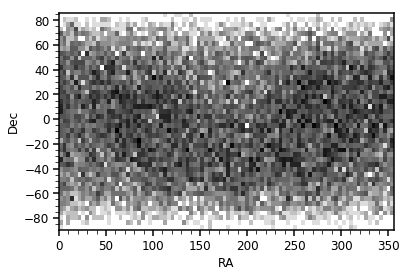

In [5]:
# check sky coverage: even at r<250pc, see a clear disc bias

# make X dmag bins
ddeg = 4.
ravals = np.arange(0,360.,ddeg)
decvals = np.arange(-90,90,ddeg)

img_Z = hist_2d(nearby['ra'][filt],nearby['dec'][filt],ravals,decvals)

plt.imshow(np.log10(img_Z),origin='lower',\
           extent=(np.nanmin(ravals),np.nanmax(ravals),np.nanmin(decvals),np.nanmax(decvals)),\
           cmap=cm.Greys,aspect='auto')


plt.xlabel('RA',size=12)
plt.ylabel('Dec',size=12)




Text(0, 0.5, '$G$')

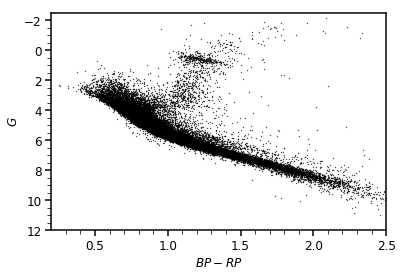

In [6]:
plax = nearby['parallax']
dist = 1000./plax

# scatter plot of HR diagram bins

# compute absolute magnitude
M = nearby['phot_g_mean_mag'] - 5*np.log10(dist) + 5

plt.scatter(nearby['bp_rp'][filt],M[filt],color='black',s=.1)


plt.axis([0.2,2.5,12.,-2.5])

plt.xlabel('$BP-RP$',size=12)
plt.ylabel('$G$',size=12)





Text(0, 0.5, '$G$')

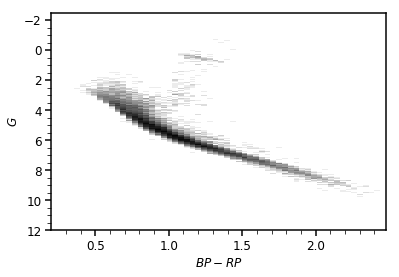

In [7]:
# HR diagram with density

# make X dmag bins
dmag = 0.04
Mvals = np.arange(12.,-2.5,-dmag)
Cvals = np.arange(0.2,2.5,dmag)

img_Z = hist_2d(nearby['bp_rp'][filt],M[filt],Cvals,Mvals)

plt.imshow(np.log10(img_Z),origin='lower',\
           extent=(np.nanmin(Cvals),np.nanmax(Cvals),np.nanmin(Mvals),np.nanmax(Mvals)),\
           cmap=cm.Greys,aspect='auto')


plt.ylim(np.nanmax(Mvals),np.nanmin(Mvals))
plt.xlabel('$BP-RP$',size=12)
plt.ylabel('$G$',size=12)



In [8]:

# coordinate transformations
# 1. to galactic
# 2. to Cartesian

raval  = (np.pi/180.)*nearby['ra'][filt]
decval = (np.pi/180.)*nearby['dec'][filt]
dist   = 1./nearby['parallax'][filt] # in kpc, with no parallax offset applied

# do coordinate transformations to galactic and Cartesian
l,b       = gt.rotate_galactic(raval,decval)
# l is defined [-pi,pi] with 0 as the galactic centre
rmul,rmub = gt.rotate_velocities(raval,decval,nearby['pmra'][filt],nearby['pmdec'][filt])

# cartesian coordinates centred on the sun
x,y,z     = gt.rotate_positions_cartesian(raval,decval,dist)
vx,vy,vz  = gt.rotate_velocities_cartesian(raval,decval,dist,nearby['pmra'][filt],nearby['pmdec'][filt],nearby['dr2_radial_velocity'][filt])


# define solar location
# use the schonrich 2010 peculiar motions
usun = 11.1
vsun = 12.24
wsun = 7.25

# use the circular velocity from ... the value of mcmillan 2017
vcirc = 232.

# use the gravity 2018 result for the galactic center distance
rsun = 8.16 # in kpc

# use the sun's height above the midplane from Bennett & Bovy (2020)...
zsun = 20.3 # in pc

Text(0, 0.5, 'V (km/s)')

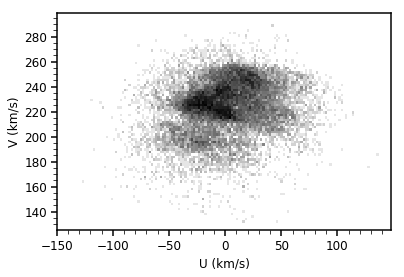

In [9]:

# U-V plane, corrected for solar reflex motion

# make X dmag bins
dv = 2.
vtvals = np.arange(125,300,dv)
vrvals = np.arange(-150,150,dv)

img_Z = hist_2d(vx+usun,vy+vcirc+vsun,vrvals,vtvals)

plt.imshow(np.log10(img_Z),origin='lower',\
           extent=(np.nanmin(vrvals),np.nanmax(vrvals),np.nanmin(vtvals),np.nanmax(vtvals)),\
           cmap=cm.Greys,aspect='auto')

plt.xlabel('U (km/s)',size=12)
plt.ylabel('V (km/s)',size=12)
